In [1]:
import pandas as pd
from scipy.io import arff
import requests
from io import StringIO
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,  confusion_matrix
from sklearn.multioutput import MultiOutputClassifier



In [2]:
# GitHub URL of the ARFF file
file_urls = [
    'https://raw.githubusercontent.com/ReuvenDerner/MSDS_QuantifyingTheWorld/main/c4_data/1year.arff',
    'https://raw.githubusercontent.com/ReuvenDerner/MSDS_QuantifyingTheWorld/main/c4_data/2year.arff',
    'https://raw.githubusercontent.com/ReuvenDerner/MSDS_QuantifyingTheWorld/main/c4_data/3year.arff',
    'https://raw.githubusercontent.com/ReuvenDerner/MSDS_QuantifyingTheWorld/main/c4_data/4year.arff',
    'https://raw.githubusercontent.com/ReuvenDerner/MSDS_QuantifyingTheWorld/main/c4_data/5year.arff'
]


In [3]:
# Initialize a list to store DataFrames for each file
dfs = []


# Load each ARFF file and store it in a DataFrame with unique column names
for i, url in enumerate(file_urls):
    response = requests.get(url)
    data = response.text
    data_io = StringIO(data)
    df, meta = arff.loadarff(data_io)
    df = pd.DataFrame(df)
    
    # Rename the columns to distinguish them by file
    df = df.rename(columns={col: f'{col}_y{i+1}' for col in df.columns})
    
    # Store the DataFrame in the list
    dfs.append(df)

# Merge the DataFrames based on the index
merged_df = dfs[0]
for i in range(1, len(dfs)):
    merged_df = pd.merge(merged_df, dfs[i], left_index=True, right_index=True)

    
merged_df

,Attr1_y1,Attr2_y1,Attr3_y1,Attr4_y1,Attr5_y1,Attr6_y1,Attr7_y1,Attr8_y1,Attr9_y1,Attr10_y1,...,Attr56_y5,Attr57_y5,Attr58_y5,Attr59_y5,Attr60_y5,Attr61_y5,Attr62_y5,Attr63_y5,Attr64_y5,class_y5
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.388250,0.249760,1.33050,1.1389,0.504940,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.25970,b'0'
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.000000,0.258340,0.99601,1.6996,0.497880,...,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.37000,b'0'
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.000000,0.309060,0.43695,1.3090,0.304080,...,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.61880,b'0'
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.149880,0.092704,1.86610,1.0571,0.573530,...,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.92990,b'0'
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.187320,0.187320,0.63070,1.1559,0.386770,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.36220,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5905,0.011007,0.30894,0.049314,1.27610,-43.6320,0.000000,0.024241,2.23690,1.0090,0.691060,...,0.020169,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990,b'1'
5906,-0.436320,0.90119,-0.142970,0.84135,-44.8010,-0.141380,-0.436320,0.10964,3.4018,0.098808,...,-0.064073,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050,b'1'
5907,0.025200,0.79799,-0.102750,0.86431,-20.1340,0.005218,0.044988,0.25316,4.6587,0.202010,...,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270,b'1'
5908,0.114830,0.65498,0.038916,1.06670,-53.0660,0.116150,0.122610,0.40355,1.1079,0.264320,...,-0.183200,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575,b'1'


In [4]:
#Verify Column Headers 
column_headers = merged_df.columns.tolist()
print(column_headers)

['Attr1_y1', 'Attr2_y1', 'Attr3_y1', 'Attr4_y1', 'Attr5_y1', 'Attr6_y1', 'Attr7_y1', 'Attr8_y1', 'Attr9_y1', 'Attr10_y1', 'Attr11_y1', 'Attr12_y1', 'Attr13_y1', 'Attr14_y1', 'Attr15_y1', 'Attr16_y1', 'Attr17_y1', 'Attr18_y1', 'Attr19_y1', 'Attr20_y1', 'Attr21_y1', 'Attr22_y1', 'Attr23_y1', 'Attr24_y1', 'Attr25_y1', 'Attr26_y1', 'Attr27_y1', 'Attr28_y1', 'Attr29_y1', 'Attr30_y1', 'Attr31_y1', 'Attr32_y1', 'Attr33_y1', 'Attr34_y1', 'Attr35_y1', 'Attr36_y1', 'Attr37_y1', 'Attr38_y1', 'Attr39_y1', 'Attr40_y1', 'Attr41_y1', 'Attr42_y1', 'Attr43_y1', 'Attr44_y1', 'Attr45_y1', 'Attr46_y1', 'Attr47_y1', 'Attr48_y1', 'Attr49_y1', 'Attr50_y1', 'Attr51_y1', 'Attr52_y1', 'Attr53_y1', 'Attr54_y1', 'Attr55_y1', 'Attr56_y1', 'Attr57_y1', 'Attr58_y1', 'Attr59_y1', 'Attr60_y1', 'Attr61_y1', 'Attr62_y1', 'Attr63_y1', 'Attr64_y1', 'class_y1', 'Attr1_y2', 'Attr2_y2', 'Attr3_y2', 'Attr4_y2', 'Attr5_y2', 'Attr6_y2', 'Attr7_y2', 'Attr8_y2', 'Attr9_y2', 'Attr10_y2', 'Attr11_y2', 'Attr12_y2', 'Attr13_y2', 'Att

In [5]:
merged_df['b'] = merged_df[['class_y1', 'class_y2', 'class_y3', 'class_y4', 'class_y5']].astype(int).max(axis=1)


In [6]:
# Count NaN values in the entire DataFrame
nan_count_df = merged_df.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {nan_count_df}")

Total NaN values in the DataFrame: 27864


In [7]:
# Count NaN values per column in the DataFrame
nan_counts = merged_df.isna().sum()

# Filter and display columns with NaN values
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)


Attr1_y1       3
Attr2_y1       3
Attr3_y1       3
Attr4_y1      26
Attr5_y1       8
            ... 
Attr59_y5      3
Attr60_y5    268
Attr61_y5     15
Attr63_y5     21
Attr64_y5    107
Length: 249, dtype: int64


In [8]:
# imputation
# Impute missing data with the mean of each column
imputed_df = merged_df.fillna(merged_df.mean())

# Count NaN values in the entire DataFrame
nan_count_df_new = imputed_df.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {nan_count_df_new}")

Total NaN values in the DataFrame: 0


In [9]:
# Split data into features (X) and multiple targets (y)
X = imputed_df.drop(columns=['b','class_y1','class_y2','class_y3','class_y4','class_y5'])
y = imputed_df['b']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Define the parameter grid for Grid Search
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=10, n_estimators=10, n_jobs= -1)

# Create Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score from the Grid Search
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score:  0.9369705918543128


|--- Attr22_y5 <= -0.10
|   |--- Attr29_y2 <= 2.96
|   |   |--- Attr34_y1 <= 6.03
|   |   |   |--- class: 1.0
|   |   |--- Attr34_y1 >  6.03
|   |   |   |--- class: 0.0
|   |--- Attr29_y2 >  2.96
|   |   |--- Attr20_y4 <= 33.10
|   |   |   |--- Attr23_y2 <= 0.05
|   |   |   |   |--- Attr25_y3 <= 0.55
|   |   |   |   |   |--- Attr15_y5 <= -3211.00
|   |   |   |   |   |   |--- Attr46_y2 <= 1.31
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- Attr46_y2 >  1.31
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Attr15_y5 >  -3211.00
|   |   |   |   |   |   |--- Attr44_y1 <= 59.65
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- Attr44_y1 >  59.65
|   |   |   |   |   |   |   |--- Attr38_y4 <= 0.33
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Attr38_y4 >  0.33
|   |   |   |   |   |   |   |   |--- Attr50_y5 <= 0.93
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |

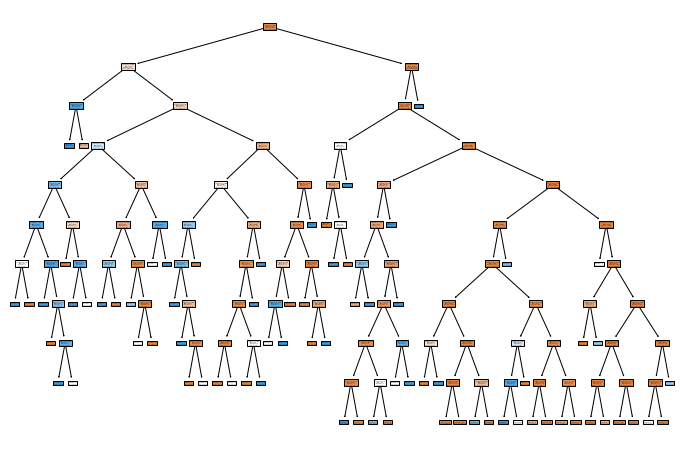

In [10]:
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 1. Train a Random Forest Classifier with the best parameters
best_params = grid_search.best_params_
rf_classifier_best = RandomForestClassifier(
    random_state=10,
    n_estimators=10,
    n_jobs=-1,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)

rf_classifier_best.fit(X_train, y_train)

# 2. Extract one of the decision trees from the trained Random Forest
tree_index = 0  # Change this index to select a different tree
selected_tree = rf_classifier_best.estimators_[tree_index]

# 3. Visualize the selected decision tree
tree_text = export_text(selected_tree, feature_names=X_train.columns.tolist())
print(tree_text)

# Optionally, you can plot the decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(selected_tree, filled=True, feature_names=X_train.columns.tolist())
plt.show()


In [11]:
# Get the best model with the optimized hyperparameters
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9314720812182741
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1093
           1       0.79      0.12      0.21        89

    accuracy                           0.93      1182
   macro avg       0.86      0.56      0.59      1182
weighted avg       0.92      0.93      0.91      1182

Confusion Matrix:
[[1090    3]
 [  78   11]]


In [12]:
# imputation
# Impute missing data with the mean of each column
imputed_df = merged_df.fillna(merged_df.mean())

# Count NaN values in the entire DataFrame
nan_count_df_new = imputed_df.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {nan_count_df_new}")

Total NaN values in the DataFrame: 0


In [13]:
# Split data into features (X) and multiple targets (y)
X = imputed_df.drop(columns=['b','class_y1','class_y2','class_y3','class_y4','class_y5'])
y = imputed_df['b']

X

,Attr1_y1,Attr2_y1,Attr3_y1,Attr4_y1,Attr5_y1,Attr6_y1,Attr7_y1,Attr8_y1,Attr9_y1,Attr10_y1,...,Attr55_y5,Attr56_y5,Attr57_y5,Attr58_y5,Attr59_y5,Attr60_y5,Attr61_y5,Attr62_y5,Attr63_y5,Attr64_y5
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.388250,0.249760,1.33050,1.1389,0.504940,...,15182.0000,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.25970
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.000000,0.258340,0.99601,1.6996,0.497880,...,2341.8000,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.37000
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.000000,0.309060,0.43695,1.3090,0.304080,...,33401.0000,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.61880
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.149880,0.092704,1.86610,1.0571,0.573530,...,2789.6000,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.92990
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.187320,0.187320,0.63070,1.1559,0.386770,...,1.2437,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.36220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5905,0.011007,0.30894,0.049314,1.27610,-43.6320,0.000000,0.024241,2.23690,1.0090,0.691060,...,3599.1000,0.020169,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990
5906,-0.436320,0.90119,-0.142970,0.84135,-44.8010,-0.141380,-0.436320,0.10964,3.4018,0.098808,...,-9242.1000,-0.064073,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050
5907,0.025200,0.79799,-0.102750,0.86431,-20.1340,0.005218,0.044988,0.25316,4.6587,0.202010,...,-58253.0000,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270
5908,0.114830,0.65498,0.038916,1.06670,-53.0660,0.116150,0.122610,0.40355,1.1079,0.264320,...,1107.5000,-0.183200,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575


In [14]:
# Split the data into training, validation, and testing sets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=10)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

In [15]:
model = xgb.XGBClassifier(
    random_state= 10,
    n_estimators = 100
)

#define the paramaters for the grid search
param_grid = {
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3,4,5],
    'min_child_weight': [1,2,3],
    'gamma': [0,0.1,0.2],
    'subsample': [0.8,0.9,1.0],
    'colsample_bytree': [0.8,0.9,1.0]

}

#create a gridsearchcv
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

#fit grid seach with stop early using a validation set
grid_search.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=10,
    verbose=1
)

#save the best paramaters as a variable and print them
best_params = grid_search.best_params_
print(f"The besst hyperparameters are : {best_params}")

#fit the model with the best parameters
best_model = xgb.XGBClassifier(
    random_state = 10,
    n_estimators = 200,
    **best_params
)

#fit model 
best_model.fit(X_train, y_train)

# make predictions
y_pred = best_model.predict(X_test)

#evaluate the best model's preformance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error : {mse}")

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[0]	validation_0-logloss:0.26437
[1]	validation_0-logloss:0.25030


C:\Users\rwbut\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-logloss:0.23765
[3]	validation_0-logloss:0.22694
[4]	validation_0-logloss:0.21878
[5]	validation_0-logloss:0.21009
[6]	validation_0-logloss:0.20359
[7]	validation_0-logloss:0.19823
[8]	validation_0-logloss:0.18973
[9]	validation_0-logloss:0.18643
[10]	validation_0-logloss:0.17882
[11]	validation_0-logloss:0.17491
[12]	validation_0-logloss:0.17034
[13]	validation_0-logloss:0.16687
[14]	validation_0-logloss:0.16273
[15]	validation_0-logloss:0.15925
[16]	validation_0-logloss:0.15716
[17]	validation_0-logloss:0.15463
[18]	validation_0-logloss:0.15125
[19]	validation_0-logloss:0.15000
[20]	validation_0-logloss:0.14849
[21]	validation_0-logloss:0.14590
[22]	validation_0-logloss:0.14386
[23]	validation_0-logloss:0.14239
[24]	validation_0-logloss:0.14166
[25]	validation_0-logloss:0.14059
[26]	validation_0-logloss:0.13911
[27]	validation_0-logloss:0.13821
[28]	validation_0-logloss:0.13762
[29]	validation_0-logloss:0.13707
[30]	validation_0-logloss:0.13494
[31]	validation_0-logl

In [16]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9644670050761421
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1096
           1       0.98      0.52      0.68        86

    accuracy                           0.96      1182
   macro avg       0.97      0.76      0.83      1182
weighted avg       0.96      0.96      0.96      1182

Confusion Matrix:
[[1095    1]
 [  41   45]]


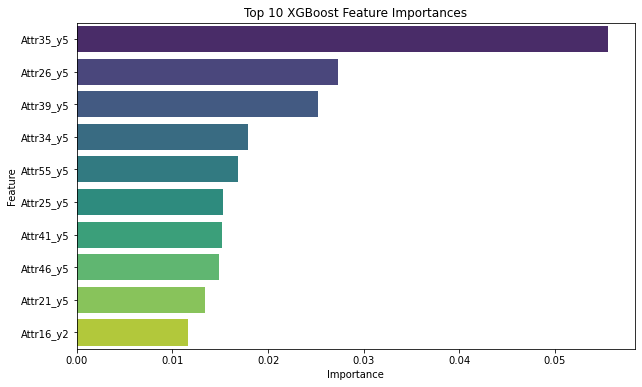

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fit model
best_model.fit(X_train, y_train)

# Get feature importances
feature_importance = best_model.feature_importances_

# Create a DataFrame to display feature importances alongside feature names
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features with the highest importances
top_10_features = feature_importance_df.head(10)

# Create a bar plot of the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, orient='h', palette='viridis')
plt.title('Top 10 XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Save the plot as a PDF file
plt.savefig('top_10_feature_importances.pdf', format='pdf')
plt.show()
